In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
sys.path.insert(0, "../src")
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# from utils.dice_score import multiclass_dice_coeff, dice_coeff
from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler


from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
# from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl

pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [51]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [52]:
results.experiment_name.unique()

array(['BaselineFullDataset', 'BaselineNoAquisition'], dtype=object)

In [53]:
results = results[results.experiment_name == "BaselineFullDataset"]
# results = results[results.dataset == "lno"]

In [54]:
results[['experiment_name','best_val_score', 'cost_function']].groupby('cost_function').mean()

,best_val_score
cost_function,
uncertainty_cost,0.96


In [91]:
results

,index,file_name,epochs,batch_size,cost_function,add_ratio,foldername,poolname,experiment_name,lr,...,seed,scale,val,amp,bilinear,classes,val_scores,num_classes,final_dice_score,best_val_score
0,0,0416265941,1000,128,uncertainty_cost,0.00,lno,lno,BaselineFullDataset,0.01,...,1,0.50,10,False,False,6,"[0.5306558609008789, 0.7434965968132019, 0.950...",3,0.96,0.96
1,5,4543548831,1000,128,uncertainty_cost,0.00,lno,lno,BaselineFullDataset,0.01,...,0,0.50,10,False,False,6,"[0.4488801956176758, 0.865180492401123, 0.9619...",3,0.96,0.96
2,8,7744788866,1000,128,uncertainty_cost,0.00,lno,lno,BaselineFullDataset,0.01,...,2,0.50,10,False,False,6,"[0.4155906140804291, 0.8366259336471558, 0.962...",3,0.95,0.96


In [56]:
results = results.reset_index()

In [86]:
x,y, _, _ = my_data.load_layer_data(oj(data_path, 'lno'))
data_mean = x[:-4].mean()
data_std = x[:-4].std()
y_second= my_data.load_single_file(oj(data_path, 'lno_second_annotation'))
y_second_formatted = np.copy(y_second)
y_second_formatted_vals = np.unique(y_second_formatted)
for i,val in enumerate(y_second_formatted_vals):
    y_second_formatted[y_second == val] = i

# y_second_formatted[y_second_formatted == 2] = 1

ImageJ series: invalid metadata or corrupted file ()


TrainSet_v2_secondAnnotation.tif
(2048, 2048)


In [78]:
net = UNet(1, 3, bilinear = results.bilinear[0]).to(device)
# load state dict
net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[0]+".pt")));
net.eval();

# Human comparison

In [100]:

test_img_np  = ((x[-1][None, ].astype(np.float32)))


In [101]:
output_list = []
output_list.append(y[-1])
output_list.append(y_second_formatted[-1])
real_val_list = []
for i in range(len(results)):
    my_models = [UNet(1, 3, bilinear = results.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 
    print(i)

    net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[i]+".pt")))
    net= net.to(device).eval()
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        nn_y = np.argmax(output, axis=0) 
        real_val_list.append(output == output.max(axis=0))
        output_list.append(np.copy(nn_y))



0
1
2


In [126]:
agreement_matrix = np.zeros((len(output_list),len(output_list)))
for i in range(len(output_list)):
    for j in range(len(output_list)):
        agreement_matrix[i,j] = (output_list[i] == output_list[j]).mean()

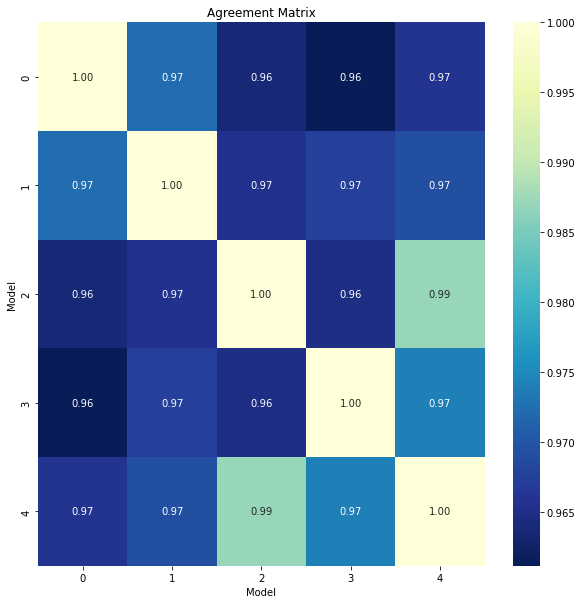

In [137]:
# plot a matrix with max and min values 0 and 1
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(agreement_matrix, annot=True, fmt=".2f", cmap="YlGnBu_r", ax=ax)
ax.set_title("Agreement Matrix")
ax.set_xlabel("Model")
ax.set_ylabel("Model")
plt.show()



In [141]:
print("NN agreement: ", (nn_y == y[-1]).mean())

NN agreement:  0.9658746719360352


In [142]:
print("NN agreement: ", (nn_y == y_second[3]).mean())

NN agreement:  0.000701904296875
